In [1]:
import os
#Set current location to the location of the script
os.chdir("/dust3r")
print(os.getcwd())

/dust3r


In [22]:
#Display imgs
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import open3d as o3d
import torch

from dust3r.inference import inference, inference_with_mask
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

DATA_PATH = "/dust3r/masked_dust3r/data/chicken"
device = 'cuda'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300


In [3]:
model_name = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [4]:
# load_images can take a list of images or a directory

images_array = []
masks_array = []

for i in range(4,7):
    images_array.append(os.path.join(DATA_PATH,"images/{}.jpg".format(i)))
    masks_array.append(os.path.join(DATA_PATH,"masks/{}.jpg.png".format(i)))
images = load_images(images_array, size=512, verbose=True)

masks = []

for i in range(len(masks_array)):
    #Open as mask and load to gpu
    mask = Image.open(masks_array[i]).convert('L')
    #Resize to match image size
    _,_,H,W = images[i]["img"].shape
    mask = mask.resize((W,H))

    mask = np.array(mask)
    mask = torch.tensor(mask).to(device)/255
    masks.append(mask)

>> Loading a list of 2 images


 - adding /dust3r/masked_dust3r/data/chicken/images/0.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/images/1.jpg with resolution 4000x3000 --> 512x384
 (Found 2 images)


In [5]:
print(images[0]["img"].shape)

torch.Size([1, 3, 384, 512])


In [6]:
print(masks[0].max())

tensor(1., device='cuda:0')


In [23]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
#output = inference_with_mask(pairs, model, device, masks, batch_size=batch_size)
output = inference(pairs, model, device, batch_size=batch_size)

view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


In [9]:
print(len(pairs))

2


In [26]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

 init edge (1*,0*) score=10.618036270141602
 init loss = 0.005255206488072872
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [00:17<00:00, 17.13it/s, lr=1.27413e-06 loss=0.00183606]


In [27]:
pointcloud1 = pts3d[0].detach().cpu().numpy()
pointcloud1 = pointcloud1.reshape(-1, 3)
color1 = imgs[0].reshape(-1, 3)

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(pointcloud1)
pcd1.colors = o3d.utility.Vector3dVector(color1)
o3d.io.write_point_cloud("pointcloud1.ply", pcd1)

pointcloud2 = pts3d[1].detach().cpu().numpy()
pointcloud2 = pointcloud2.reshape(-1, 3)
color2 = imgs[1].reshape(-1, 3)

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(pointcloud2)
pcd2.colors = o3d.utility.Vector3dVector(color2)
o3d.io.write_point_cloud("pointcloud2.ply", pcd2)

True

(-0.5, 511.5, 383.5, -0.5)

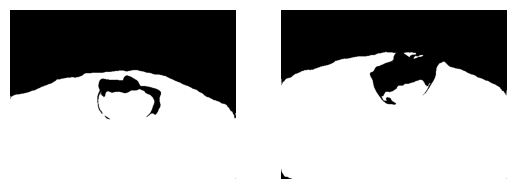

In [28]:
conf1 = confidence_masks[0].cpu().numpy()
conf2 = confidence_masks[1].cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(conf1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conf2, cmap='gray')
plt.axis('off')